In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import ml_collections as mlc
import torch
from torch.autograd.functional import jacobian
import seaborn as sns

from Empirical.data import getLogRet
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train, MaskedMSELoss, trainDenoising
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC, trainMCMCMasked
from BasicAutoEncoder.Metric import CCACorr

from Andreini_data.data import load_y

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(879, 116)


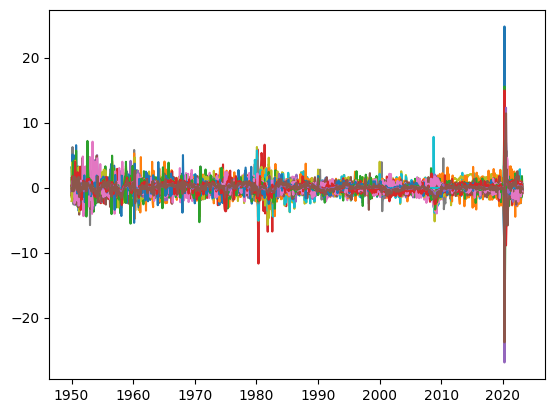

In [3]:

y, mask, index, columns= load_y(daterange=['1950-01-01', '2024-01-01'])
y[np.isnan(y)] = 0
print(y.shape)
plt.plot(index,y);

In [4]:
print(list(columns))
gdp_col = list(columns).index('GDPC1')

['PPIITM', 'PPICRM', 'PPICMM', 'CPIAUCSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAS', 'CPIULFSL', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA', 'IPMAN', 'MCUMFN', 'TCU', 'M0684AUSM343SNBR', 'M0504AUSM343SNBR', 'GDPC1', 'AMBSL', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'REALLN', 'NONREVSL', 'MZMSL', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'FEDFUNDS', 'CP3M', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'GS10', 'AAA', 'BAA', 'TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'T5YFFM', 'T10YFFM', 'AAAFFM', 'BAAFFM', 'TWEXMMTH', 'EXSZUS', 'EXJPUS', 'EXUSUK', 'EXCAUS', 'PPIFGS', 'PPIFCG', 'USWTRADE', 'USTRADE', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN', 'CES0600000008', 'CES2000000008', 'CES3000000008', 'HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW', 'DPCERA3M086SBEA', 'CMRMTSPL', 'RETAIL', 'ACOGNO', 'ANDENO', 'AMDMUO', 'M1SL', 'M2SL', 'M3SL', 'M2REAL', 'RPI', 'W875RX1', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'I

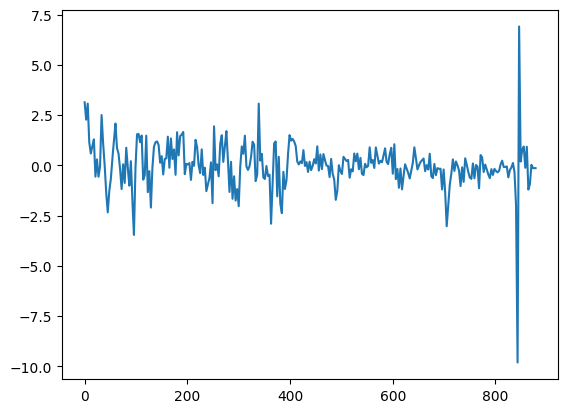

In [5]:
plt.plot(y[:,gdp_col])

(600, 116) (100, 116) (179, 116)


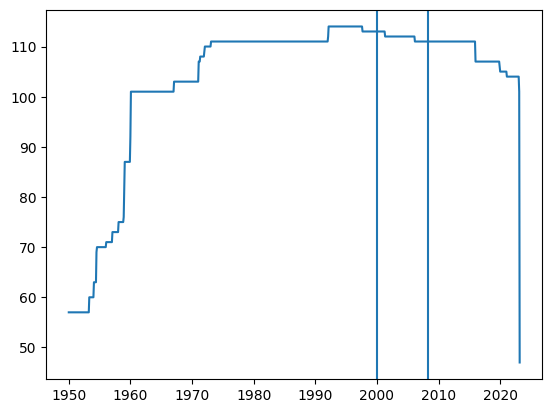

In [6]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 5
cfg.obs_dim = y.shape[1]
cfg.p_factor = 2
cfg.p_eps = 0
cfg.T_train = 600
cfg.T_test = 129
cfg.T_val = 100
cfg.T = y.shape[0] #529

#Training config
cfg.batch_size = 32
cfg.lr = 0.0001
cfg.n_epoch = 10
cfg.max_iter = 25


#Create train test val
y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]

weights_train = mask[0:cfg.T_train]
weights_val = mask[cfg.T_train:cfg.T_train+cfg.T_val]
print(y_train.shape, y_val.shape, y_test.shape)


plt.plot(index,mask.sum(axis=1))
plt.axvline(x=index[cfg.T_train])
plt.axvline(x=index[cfg.T_train+cfg.T_val])

In [7]:
weights_train.shape
y_train.shape
weights_val.shape

(100, 116)

In [17]:

cfg.lr = 0.0003
cfg.batch_size=256
cfg.max_iter = 70
cfg.n_epoch = 70
cfg.factor_dim = 3

cfg.obs_dim = y_train.shape[1]
dec = Decoder(hidden_dim=[cfg.factor_dim, 20,40,40, 80, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=True)
enc = Encoder(hidden_dim=[cfg.obs_dim, 80,40,40, 20, cfg.factor_dim], activation=nn.Tanh(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=1)
metrics = []
#y_train = np.concatenate([y_train, y_val]) #only after hyperparam tuning!!
#weights_train = np.concatenate([weights_train, weights_val])
#train_hist = train(X_train=y_train, X_val = y_val, model=mod, n_epoch=50*12, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics)
train_hist = trainMCMCMasked(X_train=y_train, X_val = y_val, weights_train=weights_train, weights_val=torch.ones(size=y_val.shape), model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter=cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

/Users/julianvanmeggelen/Thesis/Empirical/../BasicAutoEncoder/model.py:60: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(res[f"linear_{i}"].weight)


Number of trainable paramaters 30359
torch.Size([600, 116]) torch.Size([100, 116])


1 10.079783757527673757527672
2 0.37690596779187526779187524
3 0.32733791073163351073163355
4 0.26955377062161767062161766
5 0.23025064667065944667065944
6 0.22927608589331308589331308
7 0.21424017846584327846584324
8 0.22443868219852448219852448
9 0.23734915753205618753205618
10 0.2292331606149673561496735
11 0.2296562095483144254831442
12 0.2321998079617818396178183
13 0.2183250983556111735561117
14 0.2267443140347798803477988
15 0.2233180354038874240388742
16 0.2332504987716674877166748
17 0.2186294198036193880361938
18 0.2169960240523020305230203
19 0.2302802801132202111322021
20 0.2180219044287999642879996
21 0.2172616521517435615174356
22 0.2115651170412699304126993
23 0.2008498112360636323606363
24 0.2074506878852844288528442
25 0.1981095274289449142894491
26 0.2023294071356455413564554
27 0.2093954135974248359742483
28 0.1967263172070185320701853
29 0.1951140761375427213754272
30 0.1895670294761657747616577
31 0.1962342560291290302912903
32 0.1870637238025665380256653
33 0.1818

In [20]:
from forecast import saveForecastError
fc = saveForecastError(mod, "symmetric2.npy")

(179, 3)


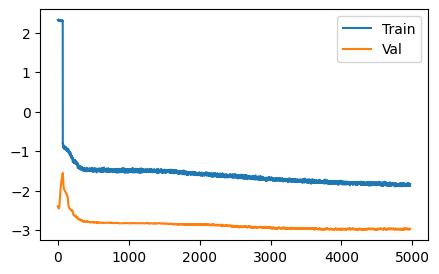

In [9]:
plot_train_hist(train_hist=train_hist, log=True)

Text(0, 0.5, 'Loss (logarithmic)')

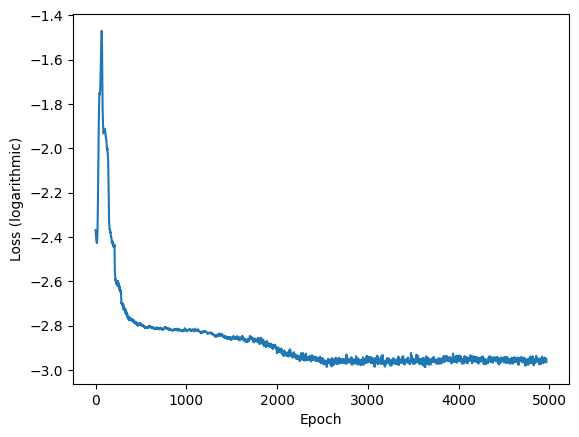

In [18]:
plt.plot(np.log(train_hist['val_loss']))
plt.xlabel('Epoch')
plt.ylabel('Loss (logarithmic)')

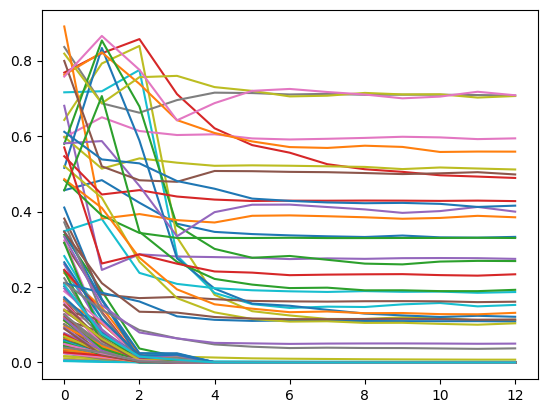

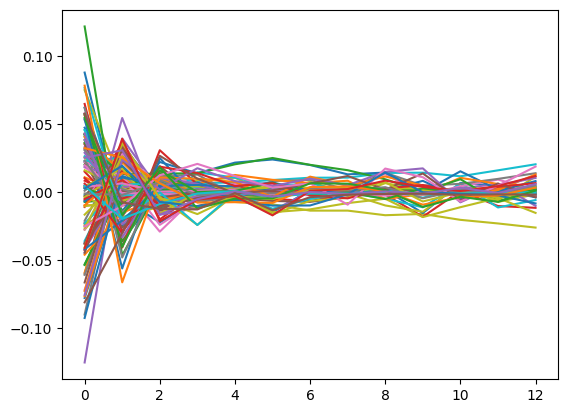

In [21]:
try:
    plt.plot([np.diag(_) for _ in errorProcess.fit_hist['cov']]);
    plt.figure()
    plt.plot(errorProcess.fit_hist['mu']);
except:
    None
try:
    plt.plot(errorProcess.fit_hist['var']);
except:
    None


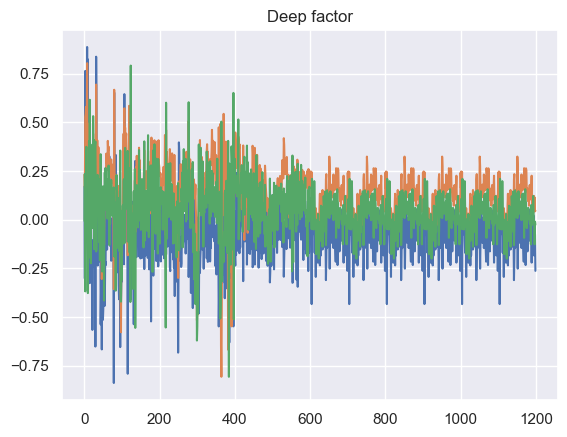

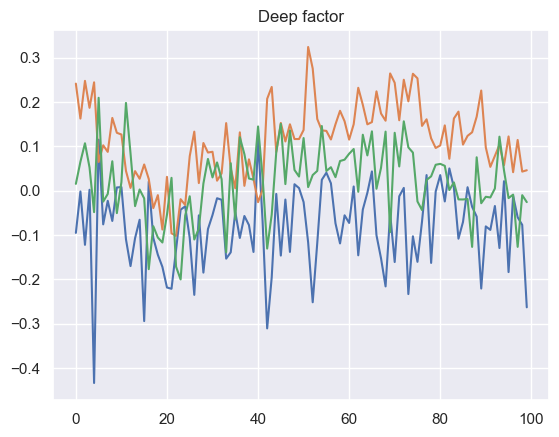

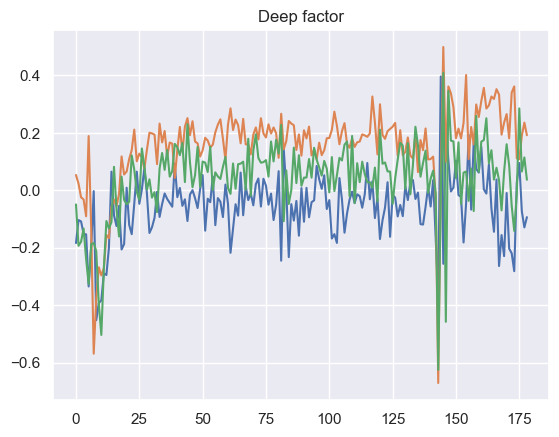

In [100]:
plot_factor_estimates(mod, y_train)
plt.figure();
plot_factor_estimates(mod, y_val)
plt.figure();
plot_factor_estimates(mod, y_test)

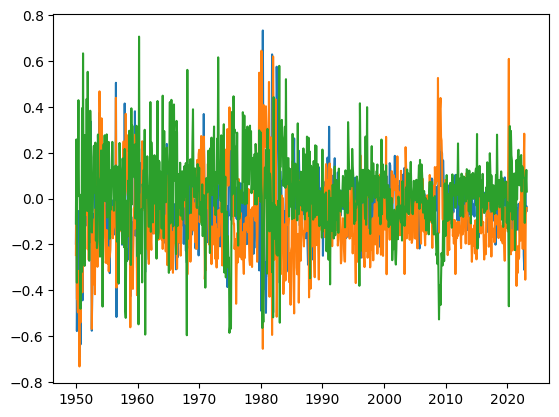

In [15]:
f_hat = mod.enc(torch.Tensor(y).float()).detach().numpy()
plt.plot(index, f_hat);

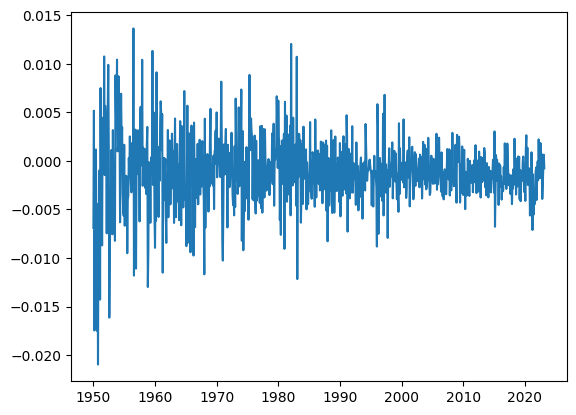

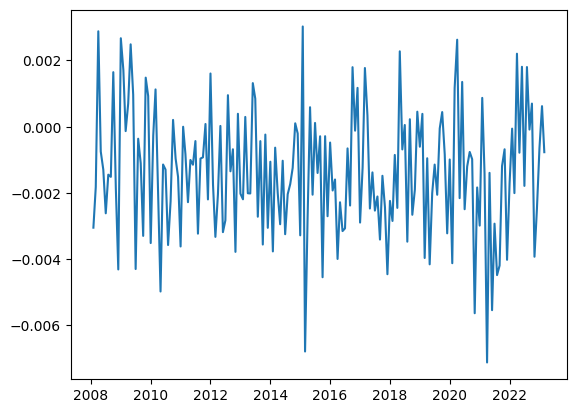

In [16]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(F, f):
    res = []
    sum = 0
    fn = fobreniusNorm(F)
    for k in range(f.shape[1]):
        for i in range(F.shape[1]):
            sum += f[:,k] * (F[k,i]**2)/fn
    return sum

F = mod.enc.sequential[0].weight.detach().numpy()
CI = computeCI(F, f_hat)

plt.plot(index,CI)
plt.figure()
i = np.argwhere(index > '2008').min()
plt.plot(index[i:],CI[i:])

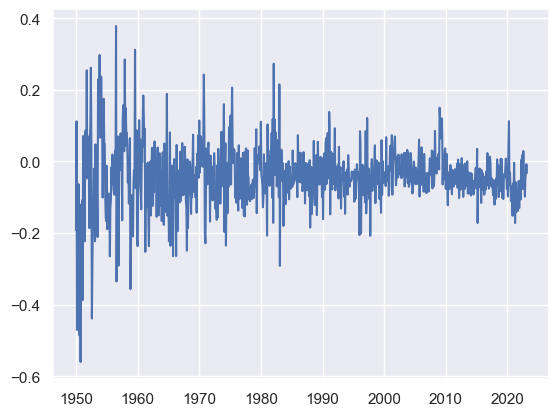

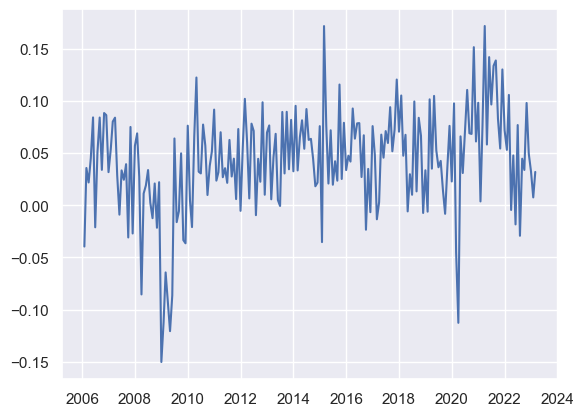

In [34]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(F, f):
    res = []
    for t in range(f.shape[0]):
        
        jac = jacobian(mod.dec, torch.Tensor(f[t]).float()).detach().numpy().T
        sum = 0
        fn = fobreniusNorm(jac)
        for k in range(f.shape[1]):
            for i in range(F.shape[1]):
                sum += f[t,k] * (jac[k,i]**2)/fn
        res.append(sum)
    return np.array(res)

def computeCI(mod, f):
    res = []
    Fs = []
    for t in range(f.shape[0]):
        F = jacobian(mod.dec, torch.Tensor(f[t]).float()).detach().numpy().T
        Fs.append(F)
        fn = fobreniusNorm(F)       
        sum = 0
        for k in range(f.shape[1]):
            for i in range(F.shape[1]):
                sum += f[t,k] * (F[k,i]**2)/fn
        res.append(sum)
    return np.array(res), np.stack(Fs)

F = mod.enc.sequential[0].weight.detach().numpy()
CI, Fs = computeCI(mod, f_hat)

plt.plot(index,CI)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],CI[i:] * (-1 if flip else 1))


Text(0.5, 109.44444444444443, '')

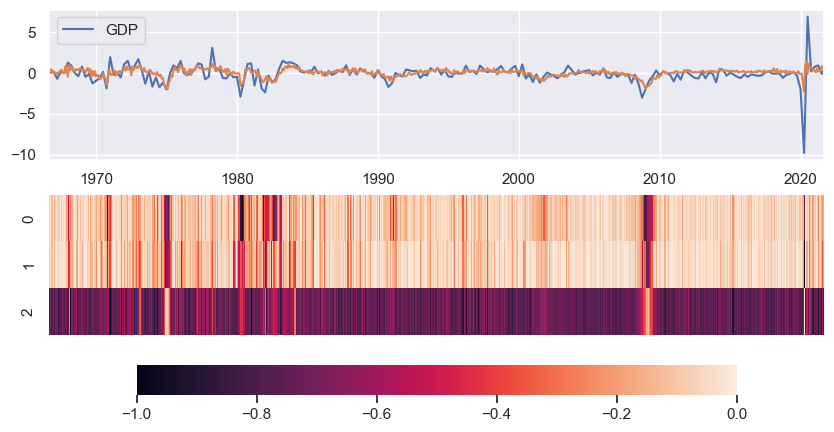

In [95]:
sns.set()
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,5), height_ratios=[1.5, 2])
i1=200
i2 =860
ax1.plot(index[i1:i2], y[i1:i2,gdp_col], label='GDP')
ax1.plot(index[i1:i2], mod(torch.from_numpy(y[i1:i2]).float()).detach().numpy()[:,gdp_col])
ax1.set_xlim(index[i1], index[i2])
ax1.legend()
Fsdf = pd.DataFrame(index=index[i1:i2].strftime('%Y-%m'), columns=["$f_1$","$f_2$","$f_3$"], data = (Fs[i1:i2,:,gdp_col]))
Fsdf_v = Fsdf.values
Fsdf_norm = (Fsdf_v - Fsdf_v.max(axis=0))/(Fsdf_v.max(axis=0) - Fsdf_v.min(axis=0))
sns.heatmap(Fsdf_norm.T, ax=ax2, xticklabels=False, cbar_kws = dict(use_gridspec=False,location="bottom"))
ax2.set_xlabel("")#(Fsdf/Fsdf.sum(axis=1)).T

In [61]:
Fsdf.max(axis=0).shape

(3,)

In [90]:
Fsdf_v = Fsdf.values
(Fsdf_v - Fsdf_v.max(axis=0))/(Fsdf_v.max(axis=0) - Fsdf_v.min(axis=0))

array([[-0.06156733, -0.06170244, -0.7720632 ],
       [-0.0269796 , -0.04001917, -0.70133835],
       [-0.13140874, -0.12377049, -0.8018232 ],
       ...,
       [-0.18298995, -0.1465896 , -0.8876069 ],
       [-0.20686515, -0.3804808 , -0.5666223 ],
       [-0.17948999, -0.17947231, -0.8065406 ]], dtype=float32)

In [82]:
Fsdf.max(axis=0) - Fsdf.min(axis=0)

$f_1$    1.341084
$f_2$    1.570301
$f_3$    1.303860
dtype: float32

In [80]:
((Fsdf.values-Fsdf.max(axis=0).values)/(Fsdf.max(axis=0) - Fsdf.min(axis=0)).values).min(axis=0)

array([-1., -1., -1.], dtype=float32)

In [41]:
Fsdf.T.values/Fsdf.sum(axis=1).values

array([[ 0.5852064 ,  0.58179456,  0.5955979 ,  0.5813836 ,  0.58451724,
         0.59726334,  0.5936587 ,  0.5826348 ,  0.581475  ,  0.5819998 ,
         0.5764482 ,  0.58879536,  0.5890803 ,  0.5811238 ,  0.5880951 ,
         0.5894821 ,  0.58719605,  0.5829386 ,  0.577865  ,  0.59059304,
         0.5801556 ,  0.58897907,  0.58567864,  0.5865928 ,  0.58159506,
         0.59069675,  0.58668315,  0.59409165,  0.5785097 ,  0.5827254 ,
         0.59573543,  0.5811547 ,  0.59340453,  0.5945531 ,  0.5862009 ,
         0.58462393,  0.5923339 ,  0.5917885 ,  0.58033663,  0.59349173,
         0.58141756,  0.5722254 ,  0.578237  ,  0.56856495,  0.59026176,
         0.5806976 ,  0.5800578 ,  0.58757514,  0.56969833,  0.58303845,
         0.5817195 ,  0.5836386 ,  0.5723278 ,  0.56983346,  0.5543436 ,
         0.6384578 ,  0.5355704 ,  0.45898992,  0.51567805,  0.54810584,
         0.5564706 ,  0.5282268 ,  0.5372856 ,  0.5222256 ,  0.56543416,
         0.5441505 ,  0.55439997,  0.5748162 ,  0.5

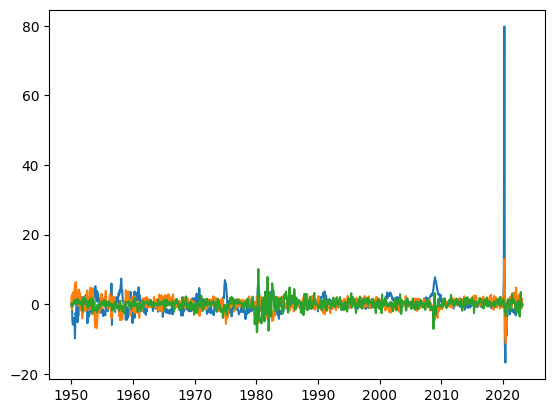

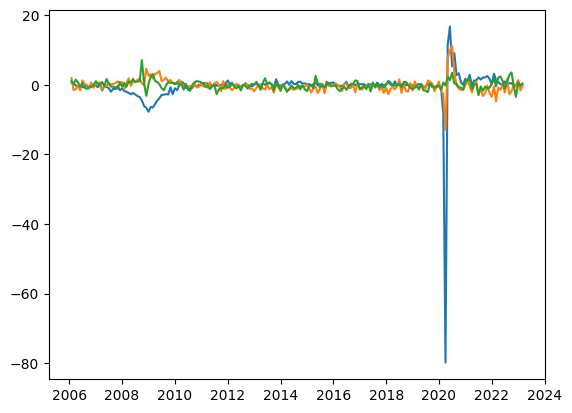

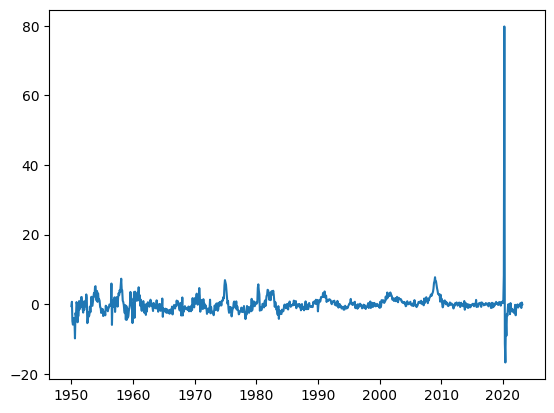

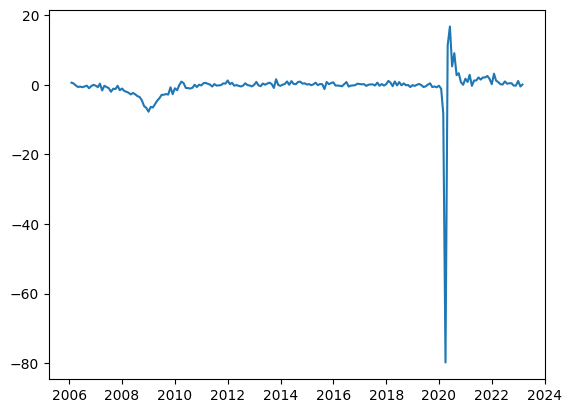

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=cfg.factor_dim)
f_hat_pca = pca.fit_transform(y)
plt.plot(index,f_hat_pca)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],f_hat_pca[i:] * (-1 if flip else 1))
plt.figure()
pca = PCA(n_components=1)
f_hat_pca = pca.fit_transform(y)
plt.plot(index,f_hat_pca)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],f_hat_pca[i:] * (-1 if flip else 1))

## Cast in statespace with EKF

In [331]:
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
varModel = VAR(np.concatenate([f_train_hat, f_val_hat]))
res = varModel.fit(maxlags=1, ic='aic')
y_hat = mod(torch.Tensor(y).float()).detach().numpy()
resid = y - y_hat
obs_cov = np.cov(resid.T)
print(res.k_ar)

1


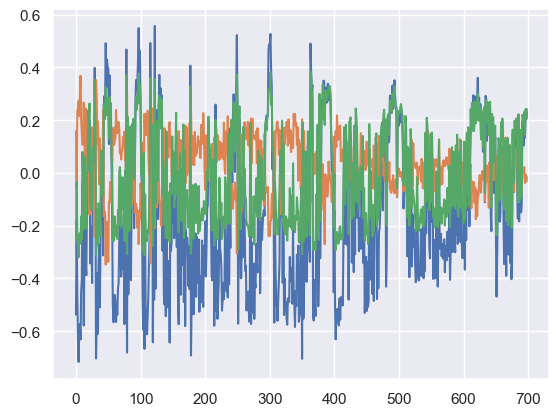

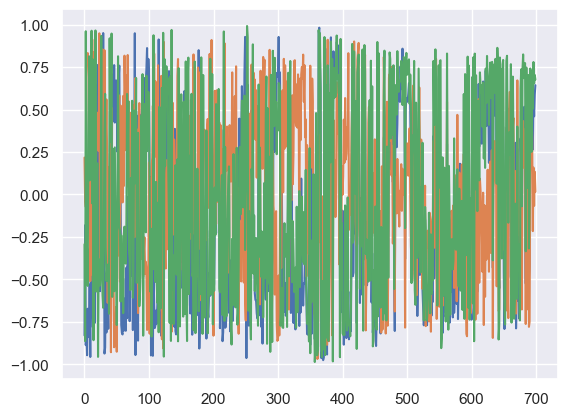

In [183]:
plt.plot(res.fittedvalues)
plt.figure()
plt.plot(np.concatenate([f_train_hat, f_val_hat]))

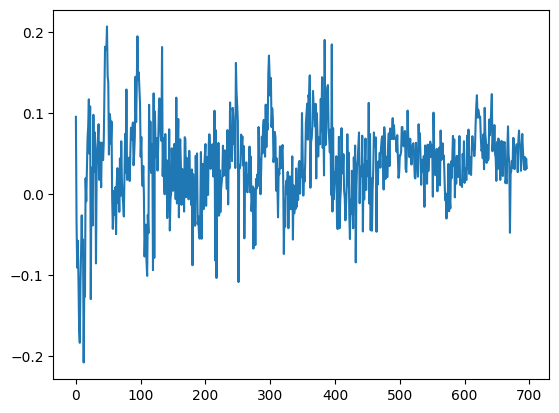

In [87]:
plt.plot(computeCI(F,res.fittedvalues))

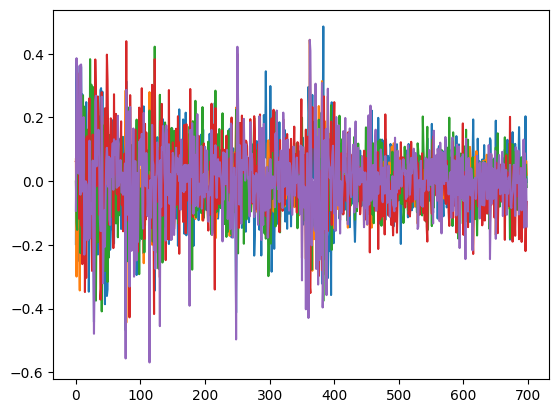

In [406]:
plt.plot(res.fittedvalues - np.concatenate([f_train_hat, f_val_hat])[1:])

<Axes: >

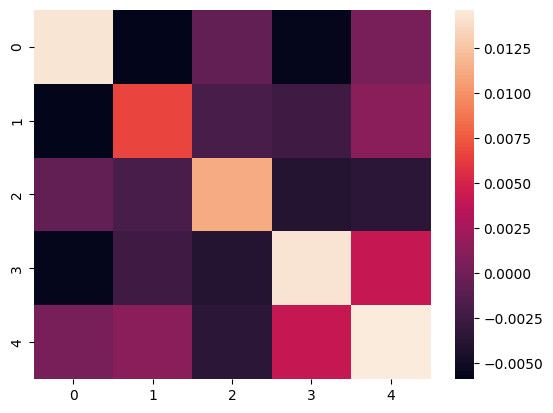

In [476]:
sns.heatmap(res.sigma_u)

<Axes: >

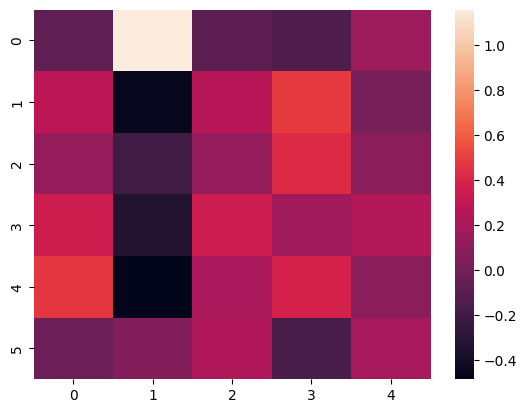

In [494]:
sns.heatmap(res.params[:])

In [88]:
from EKF.ekf import EKF, EKS, unconditionalVariance, unconditionalVariance2
y = y
Z = lambda x: mod.dec(torch.Tensor(x).float()).detach().numpy()
Z_jacobian = lambda x: jacobian(mod.dec, torch.Tensor(x).float()).detach().numpy()
H = errorProcess.cov
T = res.params[1:]
C = res.params[0]
R = np.identity(cfg.factor_dim)
Q = res.sigma_u
a0 = np.mean(f_train_hat, axis=0)
P0 = np.cov(f_train_hat.T) #None#res.sigma_u
a, P, a_filtered,Z_dot,v, K, F = EKF(y=y,Z=Z,Z_jacobian=Z_jacobian, H=H, T=T, R=R, Q=Q, C=None, a0=a0, P0=P0)


ValueError: could not broadcast input array from shape (3,) into shape (9,)

In [508]:
a_smoothed = EKS(Z_dot,F,v,a,P, T, K)

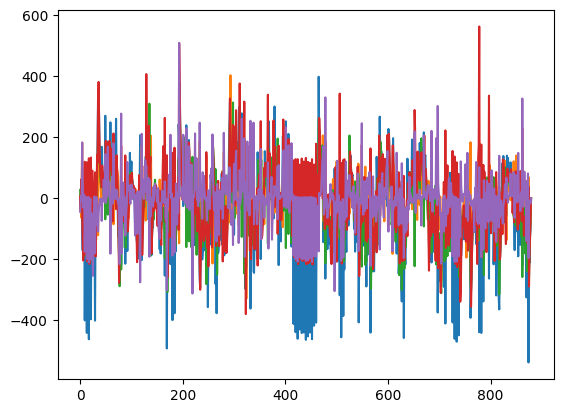

In [509]:
plt.plot(a_smoothed)

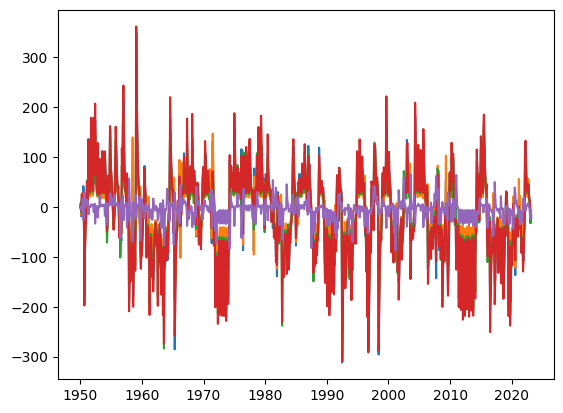

In [511]:
plt.plot(index,a[:])

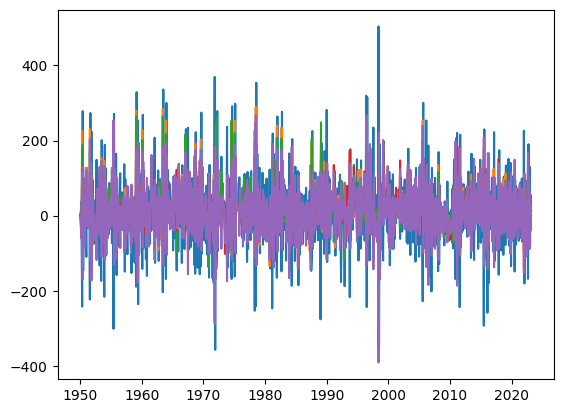

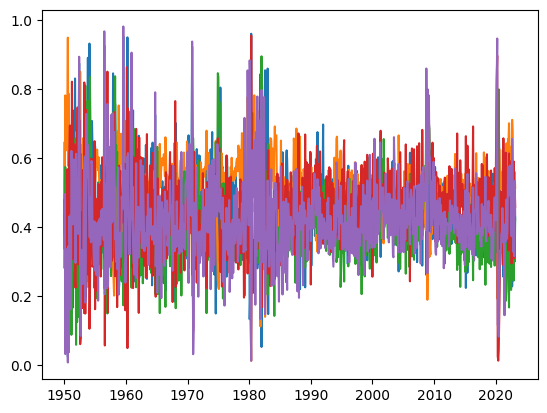

In [474]:
plt.plot(index,a)
plt.figure()
plt.plot(index,f_hat)

In [426]:
CI_filtered = computeCI(F, (a-a.max(axis=0)/(a.max(axis=0)-a.min(axis=0))))
plt.plot(CI_filtered)

/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar add
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn


/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar add
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn


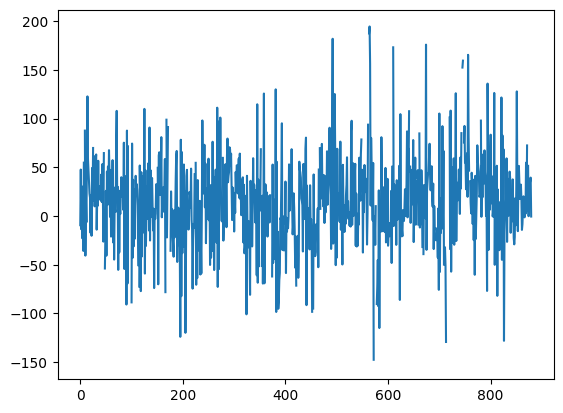

In [461]:
CI_filtered = computeCI(F, (a_smoothed-a_smoothed.max(axis=0)/(a_smoothed.max(axis=0)-a_smoothed.min(axis=0))))
plt.plot(CI_filtered)

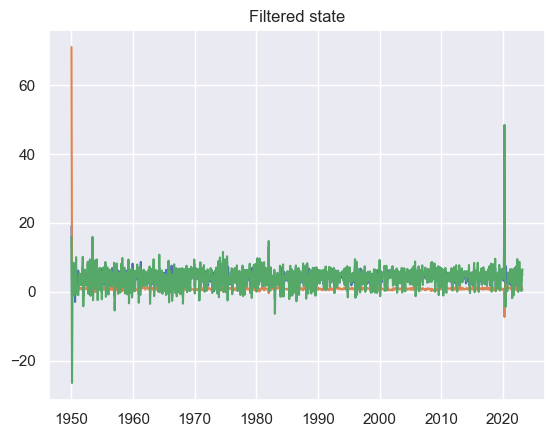

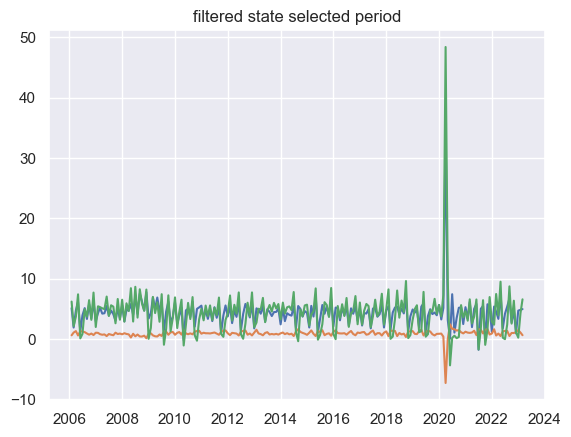

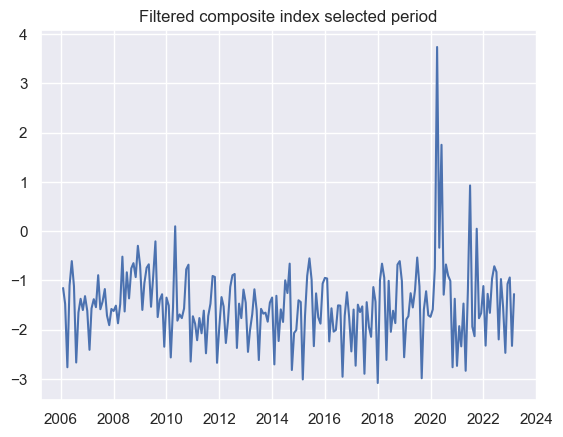

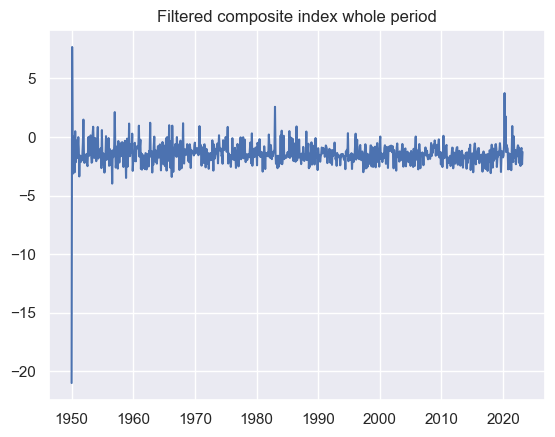

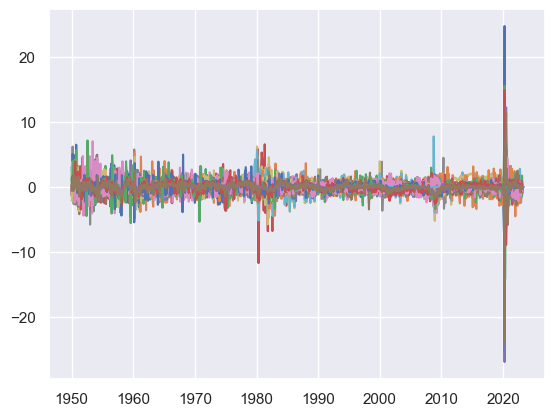

In [305]:
from filterpy.kalman import ExtendedKalmanFilter as ExtendedKalmanFilter
dim_x = cfg.factor_dim
dim_z = cfg.obs_dim
ekf = ExtendedKalmanFilter(dim_x, dim_z)
ekf.R = np.diag(np.diag(errorProcess.cov))
#ekf.R = errorProcess.cov

#ekf.R = np.diag(np.diag(obs_cov))

ekf.Q = res.sigma_u
ekf.F = res.params[1:]
ekf.P = res.sigma_u
ekf.x = f_train_hat[0]
decoder = mod.dec
Hx = lambda state: decoder(torch.Tensor(state).float()).detach().numpy()
HJacobian = lambda state: jacobian(decoder,torch.Tensor(state).float()).detach().numpy()
xs = []
zs = []
for i in range(y.shape[0]):
    z = y[i,:]
    ekf.update(z, HJacobian, Hx)
    xs.append(ekf.x)
    ekf.predict()
    zs.append(ekf.z)
plt.plot(index, np.stack(xs));
plt.title('Filtered state')
plt.title('Filtered state')
plt.figure()
i = np.argwhere((index > '2006') & (index < '2012')).min()
plt.plot(index[i:], np.stack(xs)[i:]);
plt.title('filtered state selected period')
plt.figure()
flip = True
CI_filtered,_ = computeCI(mod, np.stack(xs))
plt.plot(index[i:],CI_filtered[i:] * (-1 if flip else 1))
plt.title('Filtered composite index selected period')
plt.figure()
plt.plot(index, CI_filtered * (-1 if flip else 1))
plt.title('Filtered composite index whole period')
plt.figure()
plt.plot(index, np.stack(zs));


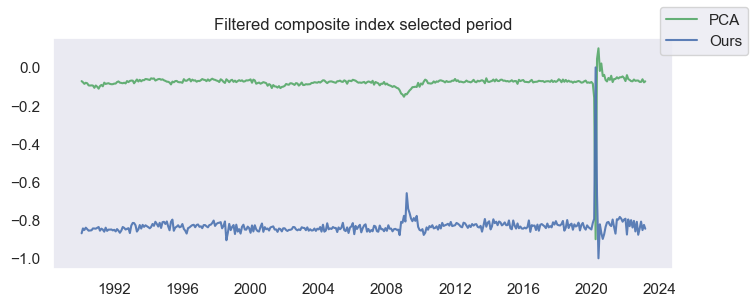

In [185]:
i = np.argwhere((index > '1990') & (index < '2012')).min()
ours = CI_filtered[i:]
flip = False
ours=(-ours if flip else ours)
ours= (ours - ours.max())/(ours.max()-ours.min())
#ours = (ours-ours.max())/(ours.max()-ours.min())
pca  = f_hat_pca[i:]
#pca = (pca-pca.max())/(pca.max()-pca.min())
#pca = pca-pca.mean()
flip=True
pca = (-pca if flip else pca)
pca= (pca - pca.max())/(pca.max()-pca.min())

fig, ax = plt.subplots(figsize=(8,3))

b =  0.1
ax.plot(index[i:],pca+b, c='C2', label='PCA', alpha=0.9)
plt.title('Filtered composite index selected period')

ax.plot(index[i:],ours , label='Ours', alpha=0.9)
ax.grid(False)
#ax = plt.twinx()

ax.grid(False)
fig.legend()

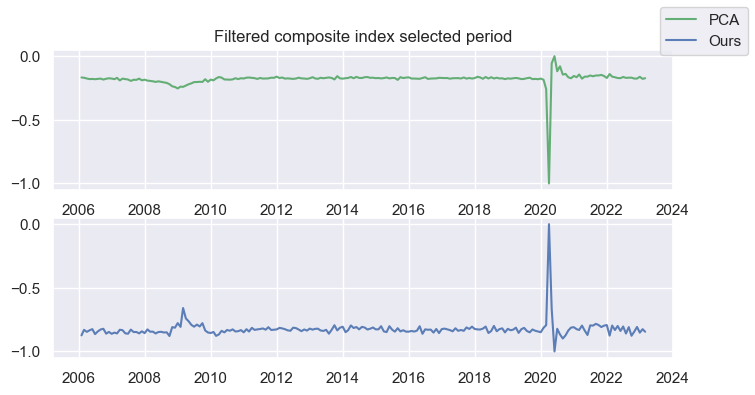

In [186]:
i = np.argwhere((index > '2006') & (index < '2012')).min()
ours = CI_filtered[i:]
flip = False
ours=(-ours if flip else ours)
ours= (ours - ours.max())/(ours.max()-ours.min())
#ours = (ours-ours.max())/(ours.max()-ours.min())
pca  = f_hat_pca[i:]
#pca = (pca-pca.max())/(pca.max()-pca.min())
#pca = pca-pca.mean()
flip=True
pca = (-pca if flip else pca)
pca= (pca - pca.max())/(pca.max()-pca.min())


fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,4))

b =  0.0
ax1.plot(index[i:],pca +b, c='C2', label='PCA', alpha=0.9)
#ax1.grid(False)

ax2.plot(index[i:],ours , label='Ours', alpha=0.9)
#ax2.grid(False)
#ax = plt.twinx()
ax1.set_title('Filtered composite index selected period')


#ax.grid(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)

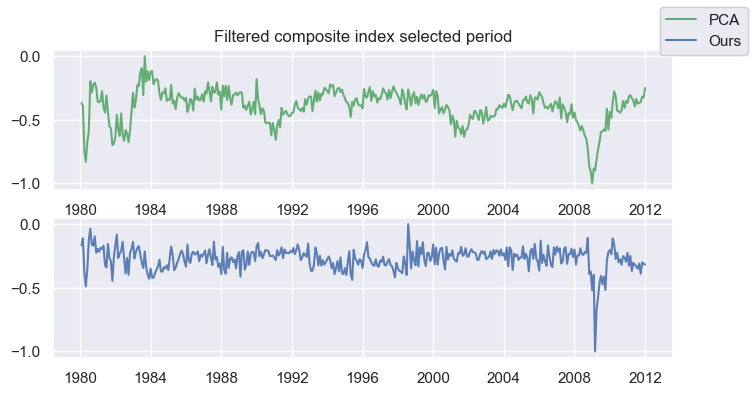

In [188]:
i_min = np.argwhere((index > '1980')).min()
i_max =  np.argwhere((index > '2012')).min()
ours = CI_filtered[i_min:i_max]
flip = True
ours=(-ours if flip else ours)
ours= (ours - ours.max())/(ours.max()-ours.min())
#ours = (ours-ours.max())/(ours.max()-ours.min())
pca  = f_hat_pca[i_min:i_max]
#pca = (pca-pca.max())/(pca.max()-pca.min())
#pca = pca-pca.mean()
flip=True
pca = (-pca if flip else pca)
pca= (pca - pca.max())/(pca.max()-pca.min())


fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,4))

b =  0.0
ax1.plot(index[i_min:i_max],pca +b, c='C2', label='PCA', alpha=0.9)
#ax1.grid(False)

ax2.plot(index[i_min:i_max],ours , label='Ours', alpha=0.9)
#ax2.grid(False)
#ax = plt.twinx()
ax1.set_title('Filtered composite index selected period')


#ax.grid(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)
ax1.set_title('Filtered composite index selected period')


#ax.grid(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)

In [173]:
CI_filtered.shape

(879,)

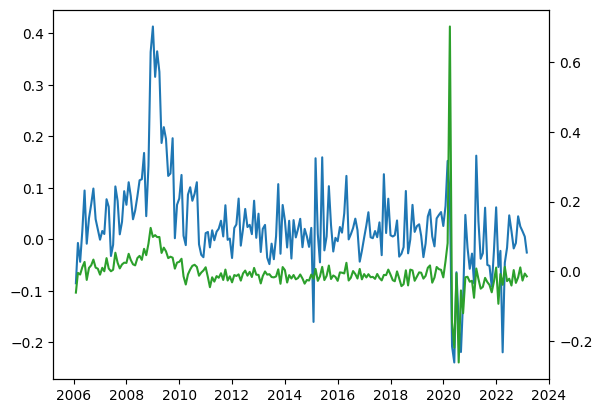

In [45]:
CI_demeaned = CI - CI.mean()
fig = plt.subplot()
plt.plot(index[i:],CI_demeaned[i:] * (-1 if flip else 1))
flip=True
fig.twinx().plot(index[i:],CI_filtered[i:] * (-1 if flip else 1), c='C2')

In [156]:
np.save(arr=CI_filtered, file='CI_filtered_ours_3')

In [157]:
np.save(arr=np.stack(xs), file='state_filtered_ours_2')

In [90]:
res = []
for i in range(1000):
    y_tilde = y_train - errorProcess.conditionalExpectation() + errorProcess.sample()
    a_tilde = mod.enc(torch.from_numpy(y_tilde).float()).detach().numpy()
    res.append(a_tilde)


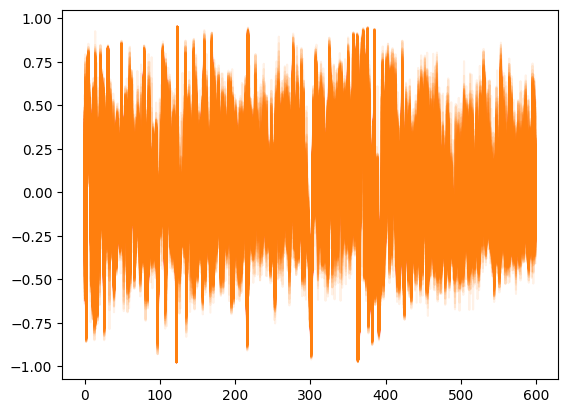

In [92]:
for i in range(1000):
    plt.plot(res[i][:,0], alpha=0.1, color='C1')

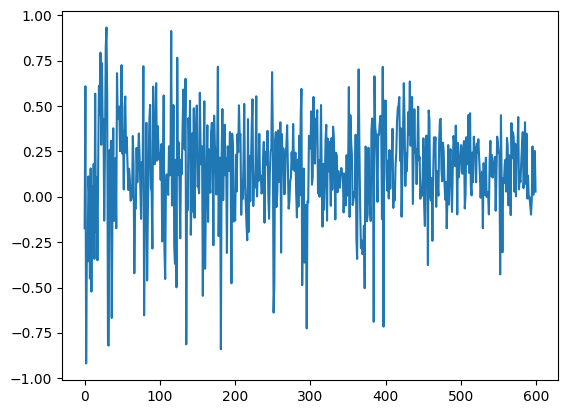

In [96]:
plt.plot(np.mean(np.stack(res),axis=0)[:,0])

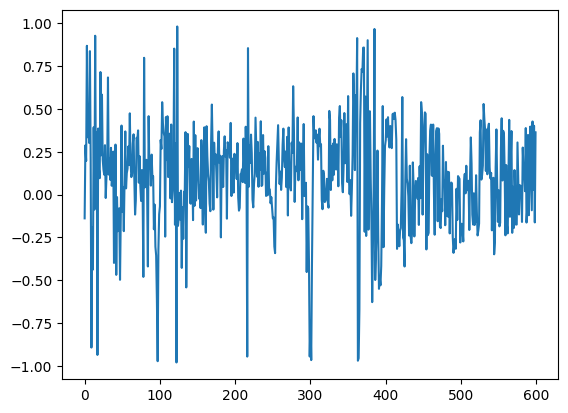

In [102]:
plt.plot(f_hat[0:600,1])

In [93]:
np.mean(np.stack(res),axis=0).shape

(600, 3)

In [767]:
np.stack(res).shape

(10, 600, 5)

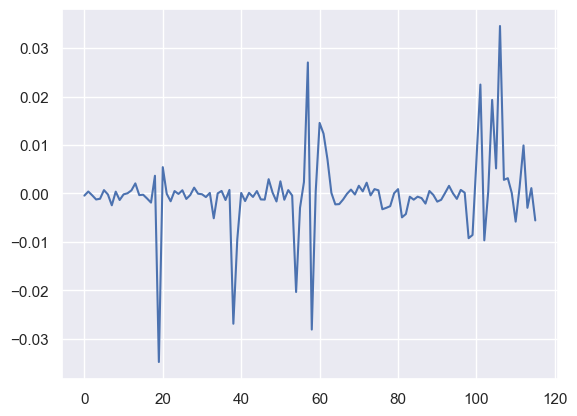

In [747]:
plt.plot(errorProcess.conditionalExpectation())

In [332]:
pred = mod(torch.from_numpy(y[cfg.T_train+cfg.T_val:]).float()).detach().numpy()
mse = (pred-y[cfg.T_train+cfg.T_val:])**2
np.save(arr=mse, file='mse_test_ours')

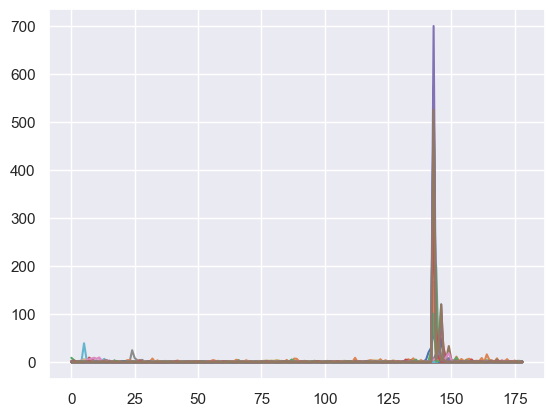

In [333]:
plt.plot(mse);

In [334]:
print(np.mean(mse))

0.4481087591148945


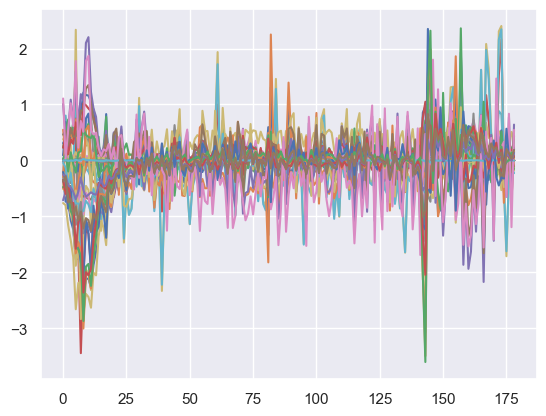

In [336]:
plt.plot(pred);

In [361]:
index[cfg.T_train+cfg.T_val:cfg.T_train+cfg.T_val+140]

DatetimeIndex(['2008-05-01', '2008-06-01', '2008-07-01', '2008-08-01',
               '2008-09-01', '2008-10-01', '2008-11-01', '2008-12-01',
               '2009-01-01', '2009-02-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=140, freq=None)